# Adjust AP-DV Plane

In [1]:
import anndata as ad

In [2]:
prefix='10dpa2'
adata  = ad.read_h5ad(f"D:/wochong_2023/body_axis/h5ad_SPC/SPC.{prefix}.h5ad")
radata = ad.read_h5ad(f'D:/wochong_2023/body_axis/APML/{prefix}.apadj.h5ad')

In [3]:
import numpy as np
import pandas as pd
import scipy.linalg as sl
import matplotlib.pyplot as plt
from skimage import io as skio

def polyfix(x, y, xfix, yfix, n=3):
    """
    This code is copy from https://github.com/jbae11/polyfix.py with minor changes 
    Fits polynomial p with degree n to data with constrains
    
    param (x,y): 2D coordinates of all training data.
    param n: degree of polynomial.
    param (xfix,yfix): 2D coordinates of all constrain points.
    """
    nfit = len(x)
    if len(y) != nfit:
        raise ValueError('x and y must have the same size')
    nfix = len(xfix)
    if len(yfix) != nfix:
        raise ValueError('xfit adn yfit must have the same size')
    x = np.vstack(x)
    y = np.vstack(y)
    if nfix > 1 :
        xfix = np.vstack(xfix)
        yfix = np.vstack(yfix)

    nspec = nfix
    specval = yfix
    # first find A and pc such that A*pc = specval
    A = np.zeros((nspec, n+1))
    # specified y values
    for i in range(n+1):
        A[:nfix, i] = np.hstack(np.ones((nfix, 1)) * xfix**(n+1-(i+1)))

    if nfix > 0:
        lastcol = n+1
        nmin = nspec - 1
    else:
        lastcol = n
        nmin = nspec

    if n < nmin:
        raise ValueError('Polynomial degree too low, cannot match all constraints')
    # find unique polynomial of degree nmin that fits the constraints
    firstcol = n-nmin
    pc0 = np.linalg.solve(A[:, firstcol:lastcol], specval)
    pc = np.zeros((n+1, 1))
    pc[firstcol:lastcol] = pc0
    
    X = np.zeros((nfit, n+1))
    for i in range(n+1):
        X[:, i] = (np.ones((nfit, 1)) * x**(n+1-(i+1))).flatten()

    yfit = y - np.polyval(pc, x)

    B = sl.null_space(A)
    #z = np.linalg.lstsq(X @ B, yfit,rcond=None)[0]
    z = np.linalg.lstsq(X @ B, yfit)[0]
    if len(z) == 0:
        z = z[0]
        p0 = B*z
    else:
        p0 = B@z
    p = np.transpose(p0) + np.transpose(pc)
    return p

def getMidline(f1, x_max, x_min, y_max, y_min,w):
    xvals = np.array(range(0,w))
    yvals = np.polyval(f1[0], xvals)
    line_df = pd.DataFrame(columns=['x','y'])
    line_df['x'] = xvals
    # half adjust
    line_df['x'] = (line_df['x']+0.5).astype('int')
    line_df['y'] = yvals
    # half adjust  
    line_df['y'] = (line_df['y']+0.5).astype('int')
    line_df = line_df[line_df['y']<y_max]
    line_df = line_df[line_df['x']<x_max]
    line_df = line_df[line_df['y']>y_min]
    line_df = line_df[line_df['x']>x_min]
    return line_df

def drawImageWithLine(x,y,line_df,w,h,prefix='draw01'):
    line = np.zeros((h,w))
    line[y,x]=200
    line[line_df['y'],line_df['x']]=255
    skio.imsave(f'{prefix}.png',line)

def scatterWithLine(x,y,line_df):
    plt.figure()
    plt.scatter(x,y,s=2)
    plt.plot(line_df['x'],line_df['y'],c='r')
    plt.gca().set_aspect('equal')
    #plt.show()

In [4]:
adata.obsm['spatial']
adata.obs['new_x'] = adata.obsm['spatial'][:,0]
adata.obs['new_y'] = adata.obsm['spatial'][:,1]
adata.obs['new_z'] = adata.obsm['spatial'][:,2]

In [5]:
c33 = adata[adata.obs['SPC_cluster']=='c33'].copy()
c33

AnnData object with n_obs × n_vars = 285 × 21579
    obs: 'seurat_clusters.r1.6', 'cell_number', 'hood', 'x', 'y', 'z', 'min_radius', 'max_radius', 'Batch', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'seurat_clusters', 'SPC_cluster', 'SPC_name', 'sample', 'new_x', 'new_y', 'new_z'
    obsm: 'spatial'

In [6]:
def update_np_APML(the_raw_pos, the_midline, f1):
    def Yinline(f1,xvals):
        return np.polyval(f1[0], xvals)
    the_result = pd.DataFrame()
    the_result['raw_x'] = the_raw_pos[:,0]
    the_result['raw_y'] = the_raw_pos[:,1]
    the_result['raw_yline'] =  Yinline(f1,the_raw_pos[:,0])

    def Ytag(item):
        if item['raw_y']>item['raw_yline']:
            return 1;
        elif item['raw_y']<item['raw_yline']:
            return -1;
        else:
            return 1
    the_result['ytag'] = the_result.apply(lambda row: Ytag(row),axis=1)
    from scipy.spatial import KDTree
    from scipy.spatial import distance
    the_line_new_points = the_midline.to_numpy()
    length = np.zeros(len(the_line_new_points))
    for i in range(1,len(the_line_new_points)):
        length[i] = distance.euclidean(the_line_new_points[i,:],the_line_new_points[i-1,:])
    length = np.cumsum(length)
    the_kdtree = KDTree(np.array(the_line_new_points))

    darray, iarray = the_kdtree.query(the_raw_pos)

    the_result['ny'] = darray
    the_result['ny'] = the_result['ny']*the_result['ytag']
    the_result['nx'] = length[np.array(iarray).astype(int)]
    return the_result

def update_adata_APML(the_data, the_midline, f1):
    the_raw_pos = the_data.obs[['new_x','new_y']].to_numpy()
    the_result = update_np_APML(the_raw_pos, the_midline, f1)
    the_data.obs['AP_adj_x'] = the_result['nx'].to_numpy()
    the_data.obs['AP_adj_y'] = the_result['ny'].to_numpy()
    return the_data

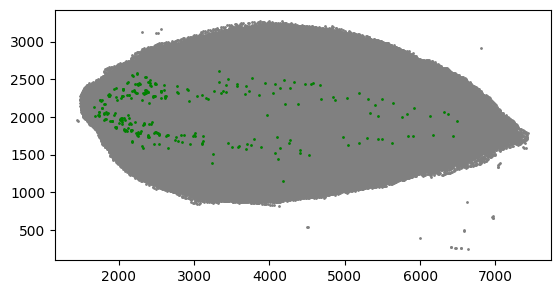

In [7]:
plt.figure()
plt.scatter(radata.obs['new_x'],radata.obs['new_y'],c='gray',s=1)
plt.scatter(c33.obs['new_x'],c33.obs['new_y'],c='green',s=1)
plt.gca().set_aspect('equal')
plt.show()

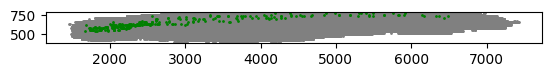

In [8]:
plt.figure()
plt.scatter(radata.obs['new_x'],radata.obs['new_z'],c='gray',s=1)
plt.scatter(c33.obs['new_x'],c33.obs['new_z'],c='green',s=1)
plt.gca().set_aspect('equal')
plt.show()

In [9]:
import numpy as np
APML_f1 = np.array([[-1.40596268e-12,  9.81619394e-09,  4.52222132e-05,        -4.61221827e-01,  2.83054135e+03]])
APML_midline = getMidline(APML_f1,7500, 1500, 3500, 500,8000)
update_adata_APML(c33,APML_midline,APML_f1)
c33

AnnData object with n_obs × n_vars = 285 × 21579
    obs: 'seurat_clusters.r1.6', 'cell_number', 'hood', 'x', 'y', 'z', 'min_radius', 'max_radius', 'Batch', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'seurat_clusters', 'SPC_cluster', 'SPC_name', 'sample', 'new_x', 'new_y', 'new_z', 'AP_adj_x', 'AP_adj_y'
    obsm: 'spatial'

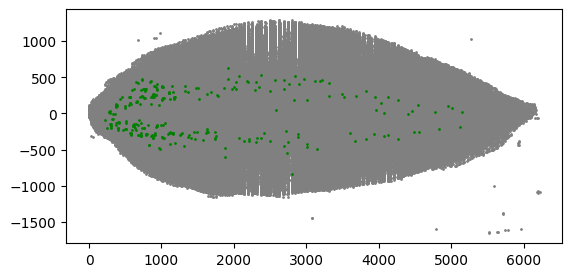

In [10]:
plt.figure()
plt.scatter(radata.obs['AP_adj_x'],radata.obs['AP_adj_y'],c='gray',s=1)
plt.scatter(c33.obs['AP_adj_x'],c33.obs['AP_adj_y'],c='green',s=1)
plt.gca().set_aspect('equal')
plt.show()

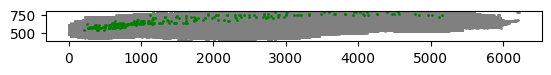

In [11]:
plt.figure()
plt.scatter(radata.obs['AP_adj_x'],radata.obs['new_z'],c='gray',s=1)
plt.scatter(c33.obs['AP_adj_x'],c33.obs['new_z'],c='green',s=1)
plt.gca().set_aspect('equal')
plt.show()

In [12]:

fixx = [100 ,6000]
fixy = [550,700]
#f1 = polyfix(used_adata.obs['new_x'].to_list(),used_adata.obs['new_y'].to_list(),fixx,fixy,n=4)
f1 =  polyfix(c33.obs['AP_adj_x'].to_list(),c33.obs['new_z'].to_list(),fixx,fixy,n=2)
#f1 = polyfix(slit1_data.obs['new_x'].to_list(),slit1_data.obs['new_y'].to_list(),fixx,fixy,n=4)
midline = getMidline(f1, 6500, 0, 850, 0,6500)

C:\Users\guolidong\AppData\Local\Temp\ipykernel_19712\727444766.py:59: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  z = np.linalg.lstsq(X @ B, yfit)[0]


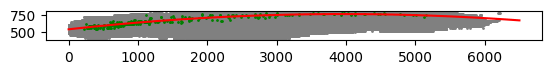

In [13]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(radata.obs['AP_adj_x'],radata.obs['new_z'],c='gray',s=1)
plt.scatter(c33.obs['AP_adj_x'],c33.obs['new_z'],c='green',s=1)
plt.plot(midline['x'],midline['y'],c='r')
plt.gca().set_aspect('equal')
plt.show()


In [14]:
f1

array([[-1.40816034e-05,  1.11321510e-01,  5.39008665e+02]])

In [15]:
def update_np(the_raw_pos, the_midline, f1):
    def Yinline(f1,xvals):
        return np.polyval(f1[0], xvals)
    the_result = pd.DataFrame()
    the_result['raw_x'] = the_raw_pos[:,0]
    the_result['raw_z'] = the_raw_pos[:,1]
    the_result['raw_yline'] =  Yinline(f1,the_raw_pos[:,0])

    def Ytag(item):
        if item['raw_z']>item['raw_yline']:
            return 1;
        elif item['raw_z']<item['raw_yline']:
            return -1;
        else:
            return 1
    the_result['ytag'] = the_result.apply(lambda row: Ytag(row),axis=1)
    from scipy.spatial import KDTree
    from scipy.spatial import distance
    the_line_new_points = the_midline.to_numpy()
    length = np.zeros(len(the_line_new_points))
    for i in range(1,len(the_line_new_points)):
        length[i] = distance.euclidean(the_line_new_points[i,:],the_line_new_points[i-1,:])
    length = np.cumsum(length)
    the_kdtree = KDTree(np.array(the_line_new_points))

    darray, iarray = the_kdtree.query(the_raw_pos)

    the_result['ny'] = darray
    the_result['ny'] = the_result['ny']*the_result['ytag']
    the_result['nx'] = length[np.array(iarray).astype(int)]
    return the_result

def update_adata(the_data, the_midline, f1):
    the_raw_pos = the_data.obs[['AP_adj_x','new_z']].to_numpy()
    the_result = update_np(the_raw_pos, the_midline, f1)
    the_data.obs['DV_adj_x'] = the_result['nx'].to_numpy()
    the_data.obs['DV_adj_z'] = the_result['ny'].to_numpy()
    return the_data

In [16]:
radata = update_adata(radata,midline,f1)
radata

AnnData object with n_obs × n_vars = 225385 × 19574
    obs: 'x', 'y', 'nSpots', 'nGenes', 'nUMI', 'sample', 'slice', 'cell_id', 'seurat_cluster_res0.8', 'new_x', 'new_y', 'z', 'seurat_cluster_res0.8_nofilter', 'seurat_cluster_res1.6', 'seurat_cluster_res1.6_nofilter', 'new_z', 'AP_adj_x', 'AP_adj_y', 'DV_adj_x', 'DV_adj_z'
    obsm: 'spatial', 'spatial_3d', 'spatial_3d_all17', 'spatial_APadj'

In [17]:
c33 = update_adata(c33,midline,f1)


In [18]:
fixed_ret = update_np(np.array([[fixx[0],fixy[0]],[fixx[1], fixy[1]]]), midline, f1)

In [19]:
mid_ret = update_np(midline.to_numpy(),midline, f1)

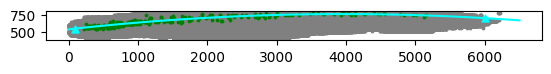

In [20]:

import matplotlib.pyplot as plt
plt.figure()
plt.scatter(radata.obs['AP_adj_x'],radata.obs['new_z'],c='gray',s=3)
plt.scatter(c33.obs['AP_adj_x'],c33.obs['new_z'],c='green',s=3)
plt.gca().set_aspect('equal')
plt.scatter(fixx,fixy,s=25,c='cyan' ,marker='^')
#plt.plot(line_df['x'],line_df['y'])
plt.plot(midline['x'],midline['y'],c='cyan')
plt.show()



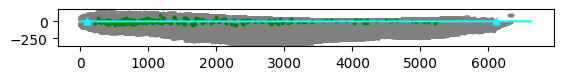

In [21]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(radata.obs['DV_adj_x'],radata.obs['DV_adj_z'],c='gray',s=3)
plt.scatter(c33.obs['DV_adj_x'],c33.obs['DV_adj_z'],c='green',s=3)
plt.gca().set_aspect('equal')
plt.scatter(fixed_ret['nx'],fixed_ret['ny'],s=25,c='cyan' ,marker='^')
plt.plot(mid_ret['nx'],mid_ret['ny'],c='cyan')

plt.show()

In [22]:
radata.obsm['spatial_DVadj'] = radata.obs[['DV_adj_x','AP_adj_y','DV_adj_z']].to_numpy()

In [23]:
radata.write(f'{prefix}.apdvadj.h5ad',compression='gzip')